In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
"""
Author : Abdulaziz Arif Suria
Date : 04/16/2024
This notebook evaluates a pretrained ViT/GPT2 Model from HuggingFace on test datset 
URL : https://huggingface.co/atasoglu/vit-gpt2-flickr8k
I have utilized my older functions from the CNN_RNN_Code folder for faster development

"""

'\nAuthor : Abdulaziz Arif Suria\nDate : 04/16/2024\nThis notebook builds a basic CNN-LSTM based architecture using transfer learning \n'

In [5]:
# Constants for file paths, working on Kaggle environment
IMAGE_FOLDER='../input/flickr8k/Images'
CAPTION_FILE='../input/flickr8k/captions.txt'

# Imports
import pandas as pd
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import spacy 
import torch
import torchvision.transforms as transforms
from collections import defaultdict
from torch.nn.utils.rnn import pad_sequence 
from torch.utils.data import DataLoader, Dataset
from PIL import Image 
from sklearn.model_selection import train_test_split
from tqdm import tqdm
!pip install rouge
from rouge import Rouge
from collections import Counter
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
from PIL import Image




  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=de9d696e6ec079ab403a190cd2e1532ac74c89a1087c9f365e2f872a004b9cee
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [7]:
# Read the Dataframe
caption_df= pd.read_csv(CAPTION_FILE,header=0)
print(f"Shape of caption_df : {caption_df.shape}")
caption_df.head()

Shape of caption_df : (40455, 2)


image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [9]:
# Group it for splitting properly in train,test and val splits
img_group_df=caption_df.groupby('image').agg(list).reset_index()
print(f'Shape of the grouped image df : {img_group_df.shape}')
img_group_df.head()

Shape of the grouped image df : (8091, 2)


image  \
0  1000268201_693b08cb0e.jpg   
1  1001773457_577c3a7d70.jpg   
2  1002674143_1b742ab4b8.jpg   
3  1003163366_44323f5815.jpg   
4  1007129816_e794419615.jpg   

                                             caption  
0  [A child in a pink dress is climbing up a set ...  
1  [A black dog and a spotted dog are fighting, A...  
2  [A little girl covered in paint sits in front ...  
3  [A man lays on a bench while his dog sits by h...  
4  [A man in an orange hat starring at something ...

In [11]:
# Validation and Test split, we will focus on Test results here
VAL_COUNT=500
TEST_COUNT=500

In [12]:
train_dataset,val_test_dataset = train_test_split(img_group_df, test_size=VAL_COUNT+TEST_COUNT, random_state=42)
val_dataset,test_dataset=train_test_split(val_test_dataset,test_size=TEST_COUNT,random_state=42)

print(f"Length of Training dataset images: {len(train_dataset)}")
print(f"Length of Validation dataset images: {len(val_dataset)}")
print(f"Length of Testing dataset images: {len(test_dataset)}")


Length of Training dataset images: 7091
Length of Validation dataset images: 500
Length of Testing dataset images: 500


In [13]:
# Get the test dataset
test_dataset=test_dataset.explode('caption').reset_index(drop=True)

In [15]:
"""
VocabBuilder class similar to the class in data_loader.py
"""
class VocabBuilder:
    def __init__(self,freq_threshold=5):
        self.idx_word_map={0:START_TOKEN,1:END_TOKEN,2:UNK_TOKEN,3:PAD_TOKEN}
        self.word_idx_map={START_TOKEN:0,END_TOKEN:1,UNK_TOKEN:2,PAD_TOKEN:3}
        self.threshold=freq_threshold
        
    def __len__(self):
        return len(self.idx_word_map)
    
    def create_vocab(self,caption_list):
        idx=4
        frequency_map=defaultdict(int)
        for caption in caption_list:
            caption_tokenized=[token.text.lower() for token in spacy_english.tokenizer(caption)]
            for word in caption_tokenized:
                frequency_map[word]+=1
                if frequency_map[word]==self.threshold:
                    self.idx_word_map[idx]=word
                    self.word_idx_map[word]=idx
                    idx+=1
                    
    def encode_text(self,caption):
        caption_tokenized=[token.text.lower() for token in spacy_english.tokenizer(caption)]
        encoded_result=[]
        for token in caption_tokenized:
            if token in self.word_idx_map:
                encoded_result.append(self.word_idx_map[token])
            else:
                encoded_result.append(self.word_idx_map[UNK_TOKEN])
        return encoded_result

In [17]:
"""
Custom Dataset class for preprocessing and establishing it in data loader
"""
class FlickrDataset(Dataset):
    def __init__(self,dataframe,transform,freq_threshold=5):
        self.transform=transform
        self.dataframe=dataframe
        self.flickr_transform=transform
        self.images=self.dataframe['image']
        self.captions=self.dataframe['caption']
        self.vocabulary=VocabBuilder(freq_threshold)
        self.vocabulary.create_vocab(self.captions)
    def __len__(self):
        return len(self.dataframe)
    def __getitem__(self,index):
        caption=self.captions[index]
        image_name=self.images[index]
        image=Image.open(os.path.join(IMAGE_FOLDER,image_name)).convert('RGB')
        image=self.transform(image)
        
        encoded_caption=[self.vocabulary.word_idx_map[START_TOKEN]]
        encoded_caption+=self.vocabulary.encode_text(caption)
        encoded_caption.append(self.vocabulary.word_idx_map[END_TOKEN])
        
        return image,torch.tensor(encoded_caption)

In [18]:
"""
Collate function similar to the data_loader class
"""
class CustomCollate:
    def __init__(self, pad_index):
        self.pad_index = pad_index

    def __call__(self, batch):
        images = [item[0].unsqueeze(0) for item in batch]
        images = torch.cat(images, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_index)

        return images, targets

In [ ]:
# Transform function for the test dataset
eval_transform= transforms.Compose(
        [
            transforms.ToTensor(),
        ]
    )

In [20]:
# The data loader class to load the test data
def get_data_loader(dataset,transform=eval_transform,batch_size=32,num_workers=4):
    curr_dataset=FlickrDataset(dataset,transform)
    pad_index=curr_dataset.vocabulary.word_idx_map[PAD_TOKEN]
    data_loader=DataLoader(
        dataset=curr_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        pin_memory=True,
        collate_fn=CustomCollate(pad_index)
    )
    return data_loader,curr_dataset

In [22]:
# Load the test dataset
test_loader, test_set=get_data_loader(test_dataset,eval_transform)

In [38]:
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
# Calculates the Rouge-L F-score for the captions and returns the best match and best score
def calculate_rouge_score(image_captions,predicted_caption):
    rouge=Rouge()
    caption_score_map={}
    for caption in image_captions:
        caption_score_map[caption]=rouge.get_scores(predicted_caption, caption)[0]['rouge-l']['f']
    best_match=max(caption_score_map,key=caption_score_map.get)
    best_score=round(caption_score_map[best_match],3)
    return (best_match,best_score)

In [28]:
# load models
feature_extractor = ViTImageProcessor.from_pretrained("atasoglu/vit-gpt2-flickr8k")
tokenizer = AutoTokenizer.from_pretrained("atasoglu/vit-gpt2-flickr8k")
model = VisionEncoderDecoderModel.from_pretrained("atasoglu/vit-gpt2-flickr8k")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

2024-04-23 16:09:54.367806: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 16:09:54.367928: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 16:09:54.524223: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/327 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/131 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.96k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/982M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/149 [00:00<?, ?B/s]

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [39]:
test_idx=0
test_images=test_set.images
test_captions=test_set.captions
rouge_score_map={}
while test_idx <len(test_captions):
    image_captions=test_captions[test_idx:test_idx+5]
    display_image= Image.open(os.path.join(IMAGE_FOLDER,test_images[test_idx]))

    # encode (extracting features)
    pixel_values = feature_extractor(images=[display_image], return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)

    # generate caption
    output_ids = model.generate(pixel_values)

    # decode
    result_caption = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0]

    best_caption,best_score=calculate_rouge_score(image_captions,result_caption)
    rouge_score_map[test_images[test_idx]]=(best_caption,result_caption,best_score)
    test_idx+=5
print(len(rouge_score_map))

500


### Evaluation of Results

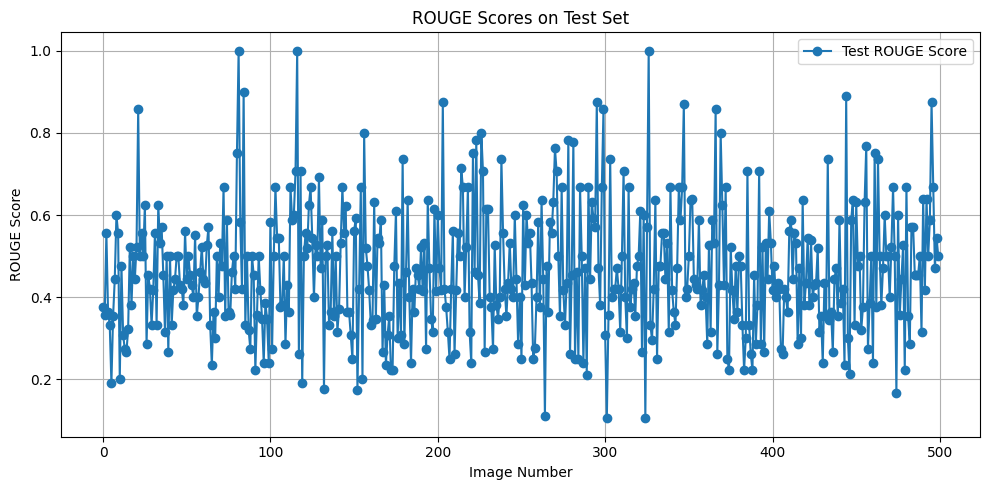

In [40]:
rouge_scores = [rouge_score_map[image][2] for image in rouge_score_map]
plt.figure(figsize=(10, 5)) 
plt.plot(rouge_scores, label='Test ROUGE Score', marker='o')  


plt.title('ROUGE Scores on Test Set')
plt.xlabel('Image Number')
plt.ylabel('ROUGE Score')


plt.legend()

plt.tight_layout()
plt.grid(True)
plt.show()

In [41]:
rouge_scores=[score_map[2] for score_map in rouge_score_map.values()]
print(f"Average Rouge Score for test set : {sum(rouge_scores)/len(rouge_scores):.3f}")

Average Rouge Score for test set : 0.464


In [44]:
# Get the top frequent words and plot them
def plot_top_frequent_words(caption_list,title,top_count=50):
    words=[]
    for caption in caption_list:
        caption_tokenized=[token.text.lower() for token in spacy_english.tokenizer(caption)]
        words.extend(caption_tokenized)
    total_freq=Counter(words)
    total_freq=total_freq.most_common(top_count)
    words, frequencies = zip(*total_freq)
    plt.figure(figsize=(12, 6))
    plt.bar(words, frequencies)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()
    
        

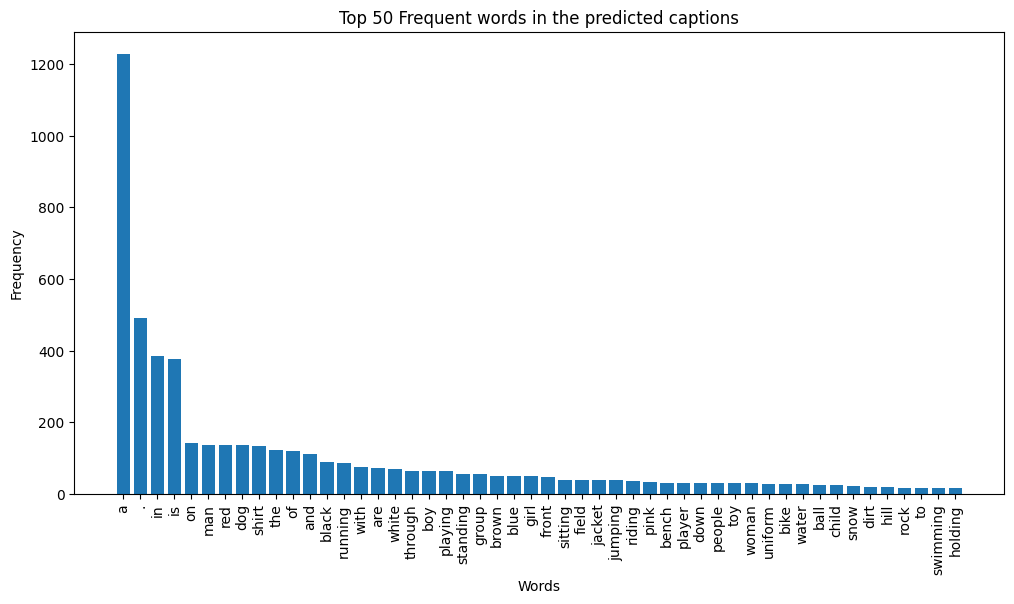

In [45]:
predicted_captions=[score_map[1] for score_map in rouge_score_map.values()]
prediction_title="Top 50 Frequent words in the predicted captions"
plot_top_frequent_words(predicted_captions,prediction_title)

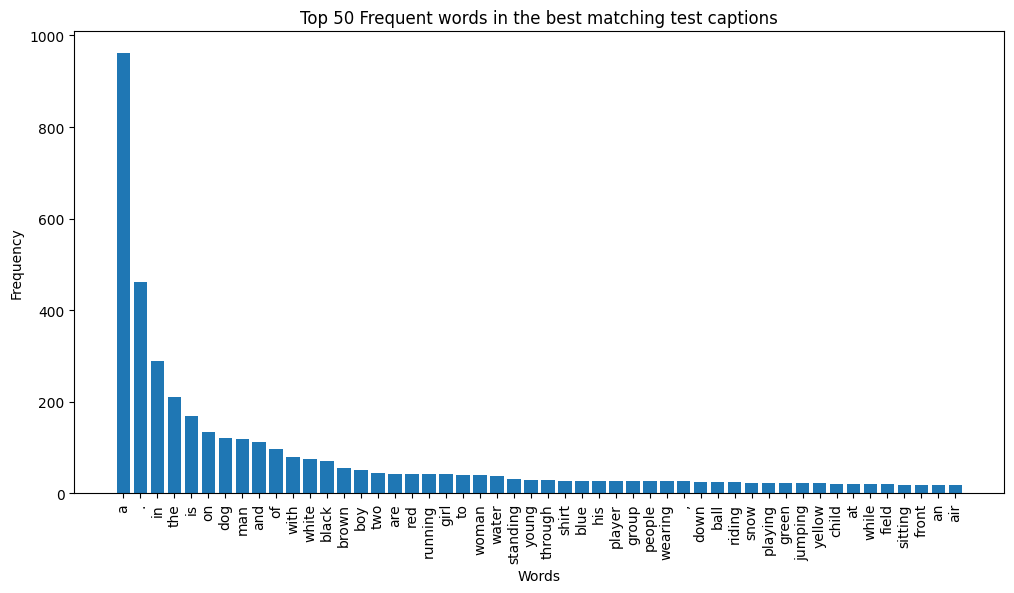

In [46]:
test_captions=[score_map[0] for score_map in rouge_score_map.values()]
test_title="Top 50 Frequent words in the best matching test captions"
plot_top_frequent_words(test_captions,test_title)

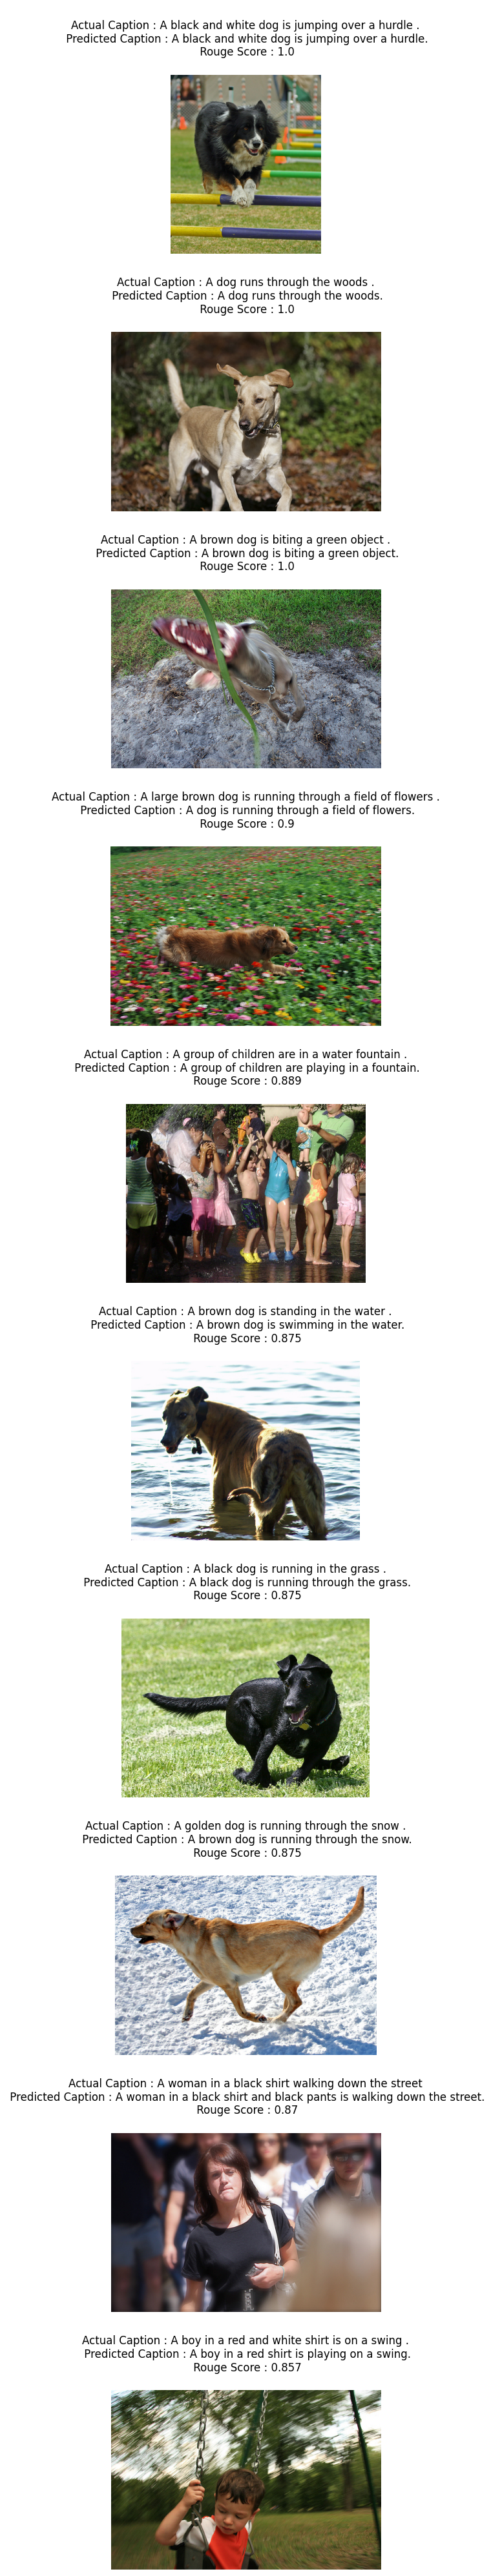

In [47]:
image_fig, axes = plt.subplots(10, 1, figsize=(16, 40))
ax_idx=0
best_results=dict(sorted(rouge_score_map.items(),key=lambda x : x[1][2],reverse=True)[:10])
for image,caption_data in best_results.items():
    display_image= Image.open(os.path.join(IMAGE_FOLDER,image))
    axes[ax_idx].imshow(display_image)
    best_caption,predicted_caption,score=caption_data
    axes[ax_idx].set_title(f"\nActual Caption : {best_caption}\n Predicted Caption : {predicted_caption}\n Rouge Score : {score}\n")
    axes[ax_idx].axis('off')
    ax_idx+=1

plt.tight_layout()
plt.show()


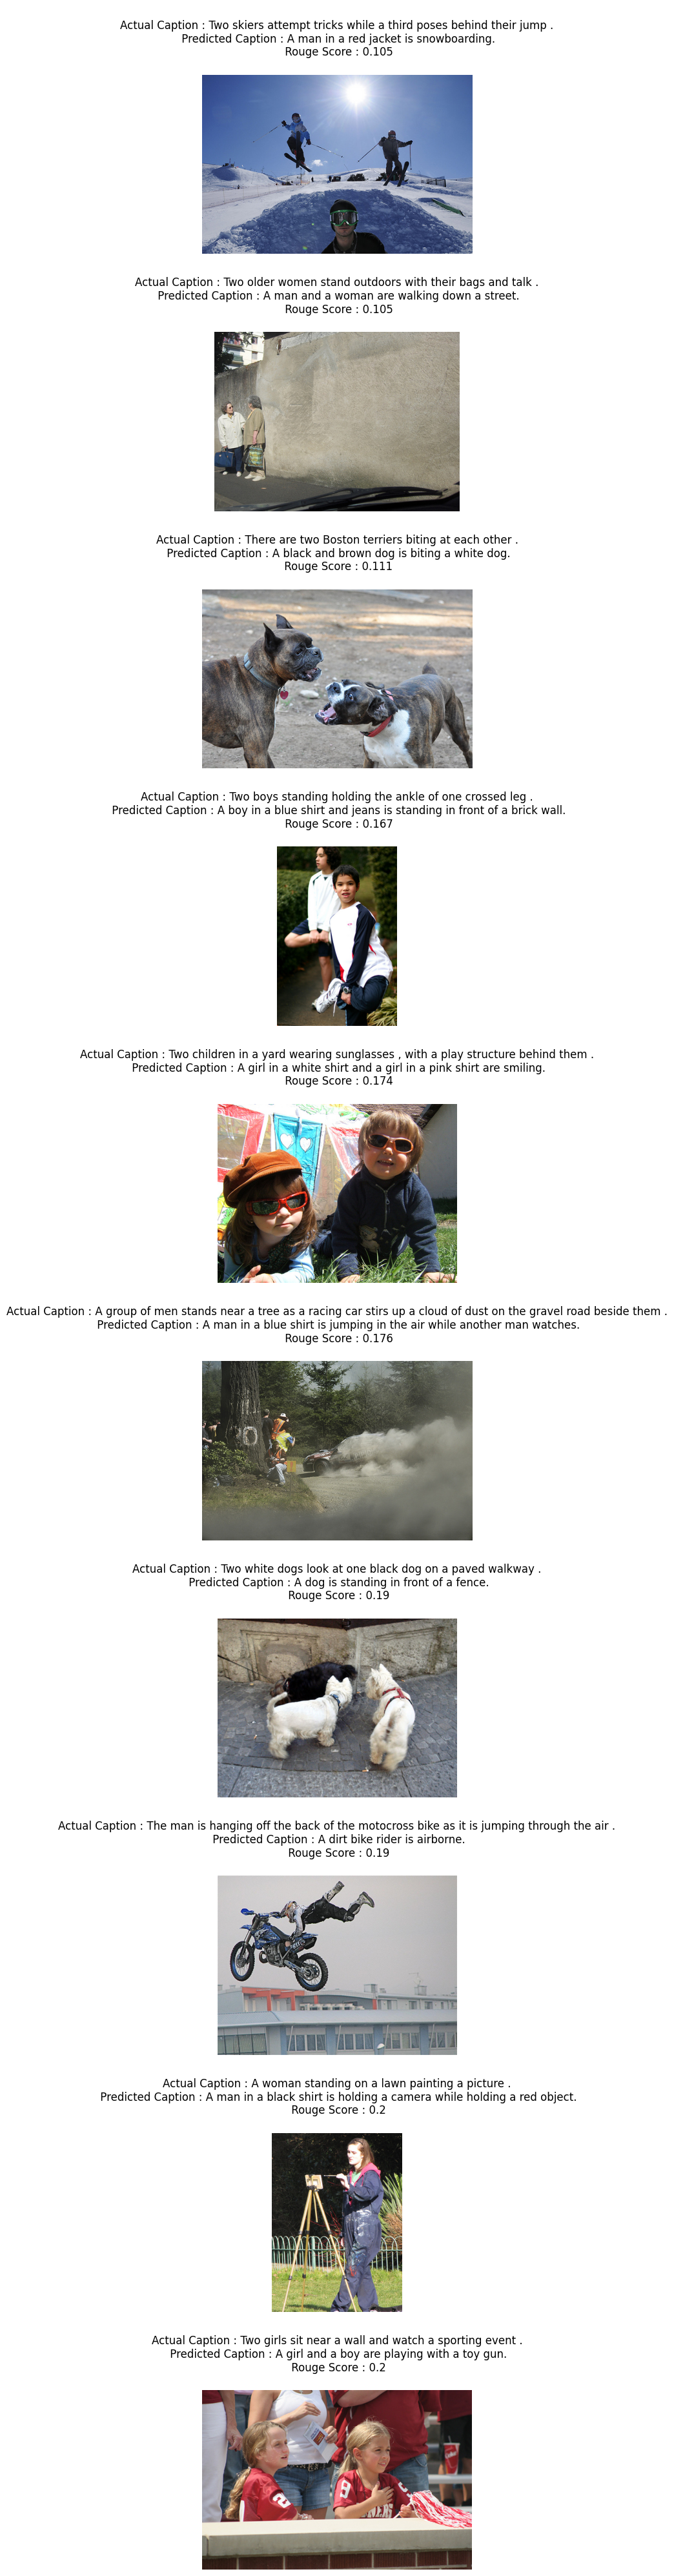

In [48]:
image_fig, axes = plt.subplots(10, 1, figsize=(16, 40))
ax_idx=0
best_results=dict(sorted(rouge_score_map.items(),key=lambda x : x[1][2])[:10])
for image,caption_data in best_results.items():
    display_image= Image.open(os.path.join(IMAGE_FOLDER,image))
    axes[ax_idx].imshow(display_image)
    best_caption,predicted_caption,score=caption_data
    axes[ax_idx].set_title(f"\nActual Caption : {best_caption}\n Predicted Caption : {predicted_caption}\n Rouge Score : {score}\n")
    axes[ax_idx].axis('off')
    ax_idx+=1

plt.tight_layout()
plt.show()